# Temperature Analysis II 

In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [42]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Challenge Assignment

In [62]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [137]:
# Find first and last date for data one year ago from upcomming vacation week
# Upcomming trip is for future (August 1-7, 2018) then subrtact one year

chosen_date_start = '2018-08-01'
chosen_date_end = '2018-08-07'

chosen_date_start = dt.datetime.strptime(chosen_date_start, '%Y-%m-%d')
chosen_date_end =  dt.datetime.strptime(chosen_date_end, '%Y-%m-%d')

year_ago_start = chosen_date_start - dt.timedelta(365)
year_ago_end = chosen_date_end - dt.timedelta(365)

print(f"Beginning of year ago trip:  = {year_ago_start}")
print(f"End of year ago trip: = {year_ago_end}")

Beginning of year ago trip:  = 2017-08-01 00:00:00
End of year ago trip: = 2017-08-07 00:00:00


In [138]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
# Year ago must come before last date
ttemps = calc_temps(year_ago_start, year_ago_end)

min_temp = ttemps[0][0]
avg_temp = round(ttemps[0][1], 2)
max_temp = ttemps[0][2]

print(f'Min Temp: {min_temp} F')
print(f'Avg Temp: {avg_temp} F')
print(f'Max Temp: {max_temp} F')

Min Temp: 73.0 F
Avg Temp: 80.04 F
Max Temp: 83.0 F


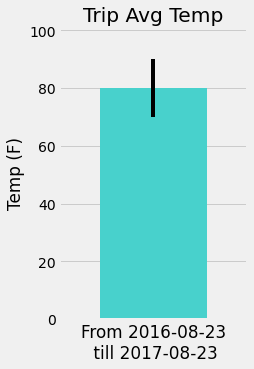

In [142]:
# Plot the results from previous query as a bar chart. 
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_value = [1]
y_value = avg_temp
error = (max_temp-min_temp)

plt.figure(figsize=(3,5))
plt.bar(x_value, y_value, yerr=error, color = 'mediumturquoise')

plt.title("Trip Avg Temp")

plt.xlim(0.3, 1.7)
plt.tick_params(axis='x', labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.xlabel(f'From 2016-08-23\n till 2017-08-23')

plt.ylim(0, 101)
plt.grid(which='major', axis='y', linestyle='-')
plt.ylabel("Temp (F)")

plt.savefig("images/trip_avg_temp.png")
plt.show()

### Daily Rainfall Average

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
session.close()